<a href="https://colab.research.google.com/github/VardhanVelamakanni/Mental_stres_Prediction_BandDecomposition_CWT/blob/main/Pipeline1(EEG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Raw data mat.zip to Raw data mat.zip
Saving Documents and Code.zip to Documents and Code.zip
Saving DASPS+HAM labels.zip to DASPS+HAM labels.zip


In [2]:
import os

BASE_DIR = "/content/DASPS"
os.makedirs(BASE_DIR, exist_ok=True)
print("directory created:", BASE_DIR)


directory created: /content/DASPS


In [3]:
import shutil

for file in uploaded.keys():
    shutil.move(file, BASE_DIR + "/" + file)

os.listdir(BASE_DIR)


['DASPS+HAM labels.zip', 'Raw data mat.zip', 'Documents and Code.zip']

In [4]:
import zipfile

def unzip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip("/content/DASPS/Raw data mat.zip", BASE_DIR)
unzip("/content/DASPS/DASPS+HAM labels.zip", BASE_DIR)

print("Extraction complete")


Extraction complete


In [5]:
!pip install h5py scipy matplotlib numpy


In [6]:
import h5py
import numpy as np

file_path = "/content/DASPS/Raw data mat/S01.mat"

f = h5py.File(file_path, 'r')
key = list(f.keys())[0]
eeg = np.array(f[key])

print("EEG shape:", eeg.shape)


EEG shape: (12, 1920, 14)


In [11]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, low=1, high=40, fs=128, order=4):
    nyq = 0.5 * fs
    low=low/nyq
    high=high/ nyq
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal, padlen=0)


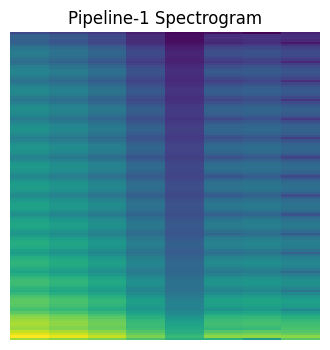

In [13]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

FS = 128

# Select the first channel from the first instance of the EEG data
signal = eeg[0, :, 0]
filtered = bandpass_filter(signal)

f, t, Sxx = spectrogram(filtered, FS)

plt.figure(figsize=(4,4))
plt.pcolormesh(t, f, 10*np.log10(Sxx))
plt.title("Pipeline-1 Spectrogram")
plt.axis("off")
plt.show()

In [14]:
os.makedirs("/content/images/stress", exist_ok=True)
os.makedirs("/content/images/no_stress", exist_ok=True)


In [15]:
def save_spectrogram(signal, save_path):
    f, t, Sxx = spectrogram(signal, FS)
    plt.figure(figsize=(3,3))
    plt.pcolormesh(t, f, 10*np.log10(Sxx))
    plt.axis("off")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [18]:
for ch_idx in range(eeg.shape[0]):
    for inst_idx in range(eeg.shape[2]):

        signal = eeg[ch_idx, :, inst_idx]
        filtered = bandpass_filter(signal)

        save_path = f"/content/images/stress/S01_CH{ch_idx}_INST{inst_idx}.png"
        save_spectrogram(filtered, save_path)

In [19]:
os.listdir("/content/images/stress")[:5]


['S01_CH0_INST7.png',
 'S01_CH3_INST7.png',
 'S01_CH0_INST13.png',
 'S01_CH7_INST10.png',
 'S01_CH1_INST12.png']

In [21]:
DATA_PATH = "/content/DASPS/Raw data mat"

for file in os.listdir(DATA_PATH):
    subject_id = file.replace(".mat","")

    f = h5py.File(DATA_PATH + "/" + file, 'r')
    key = list(f.keys())[0]
    eeg = np.array(f[key]) # e.g., (channels, time_points, instances)

    for ch_idx in range(eeg.shape[0]): # Iterate over channels
        for inst_idx in range(eeg.shape[2]): # Iterate over instances
            signal = eeg[ch_idx, :, inst_idx] # Extract a single 1D signal for a specific channel and instance
            filtered = bandpass_filter(signal)
            save_spectrogram(filtered,
                             f"/content/images/stress/{subject_id}_CH{ch_idx}_INST{inst_idx}.png")

Till,here images are generated and are yet to be assigned labels and split into train,val and test

In [22]:
!pip install h5py numpy scikit-learn


In [23]:
import h5py
import numpy as np

label_file = "/content/DASPS/DASPS+HAM labels/DASPS+HAM labels.mat"

f = h5py.File(label_file, 'r')
print(list(f.keys()))


['#refs#', 'Regim_datasub']


In [24]:
labels = np.array(f[list(f.keys())[0]])
labels = labels.squeeze()

print("Total subjects:", len(labels))
print("First 10 labels:", labels[:10])


Total subjects: 553
First 10 labels: ['0' '0b' '0c' '0d' '0e' '0f' '0g' '0h' '1' '1b']


In [25]:
import os

BASE = "/content/dataset"

folders = [
    "train/stress","train/no_stress",
    "val/stress","val/no_stress",
    "test/stress","test/no_stress"
]

for fldr in folders:
    os.makedirs(os.path.join(BASE,fldr), exist_ok=True)

print("Folders created.")


Folders created.


In [26]:
import glob

image_files = glob.glob("/content/images/stress/*.png")
print("Total images:", len(image_files))


Total images: 3864


In [29]:
import os

print("Generated images:", len(os.listdir("/content/images/stress")))


Generated images: 3864


In [30]:
import shutil, os

if os.path.exists("/content/dataset"):
    shutil.rmtree("/content/dataset")

os.makedirs("/content/dataset", exist_ok=True)
print("Clean dataset folder created.")


Clean dataset folder created.


In [31]:
BASE = "/content/dataset"

folders = [
    "train/stress","train/no_stress",
    "val/stress","val/no_stress",
    "test/stress","test/no_stress"
]

for fldr in folders:
    os.makedirs(os.path.join(BASE,fldr), exist_ok=True)


In [32]:
import glob, shutil, os

image_files = glob.glob("/content/images/stress/*.png")

def get_binary_label(label):
    label = label.decode() if isinstance(label, bytes) else str(label)
    return 1 if label[0] == '1' else 0

for img in image_files:
    name = os.path.basename(img)
    subject = name.split("_")[0]
    sid = int(subject.replace("S","")) - 1

    label = get_binary_label(labels[sid])

    if label == 1:
        shutil.copy(img, f"{BASE}/train/stress/{name}")
    else:
        shutil.copy(img, f"{BASE}/train/no_stress/{name}")


In [33]:
print("Stress images:", len(os.listdir(f"{BASE}/train/stress")))
print("No-stress images:", len(os.listdir(f"{BASE}/train/no_stress")))


Stress images: 1512
No-stress images: 2352


In [34]:
from sklearn.model_selection import train_test_split
import shutil

def split_class(class_name):
    path = f"{BASE}/train/{class_name}"
    files = os.listdir(path)

    train, temp = train_test_split(files, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    for f in val:
        shutil.move(f"{path}/{f}", f"{BASE}/val/{class_name}/{f}")
    for f in test:
        shutil.move(f"{path}/{f}", f"{BASE}/test/{class_name}/{f}")

split_class("stress")
split_class("no_stress")


In [35]:
import shutil

shutil.make_archive(
    "/content/Pipeline1_dataset",
    "zip",
    "/content/dataset"
)

print("Zip file created!")


Zip file created!


In [36]:
from google.colab import files
files.download("/content/Pipeline1_dataset.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>